In [1]:
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##Model background
Here is an example based on the model of Freyberg, 1988.  The synthetic model is a 2-dimensional MODFLOW model (X-Z domain) with 1 layer,  40 rows, and 20 columns.  The model has 3 stress periods: an initial steady-state stress period used for calibration, a 5-year transient stress period and a final steady-state stress period.  THe calibration period uses the recharge and well flux of Freyberg, 1988; the last two stress periods use 25% less recharge and 25% more pumping.

The inverse problem has 703 parameters: hydraulic conductivity of each active model cell, calibration and forecast period recharge multipliers, storage and specific yeild, well flux for each of the six wells, and river bed conductance for each river-type boundary.  The inverse problem has 13 head obseravtions, measured at the end of the steady-state calibration period.  The forecasts of interest include the sw-gw exchange flux during all three stress periods, the water level in each of the well cells at the end of the stress periods and the travel time from a point near the left edge of the model domain to a boundary condition (see figure).  The forecasts are included in the Jacobian matrix as zero-weight observations. The model files, pest control file and previously-calculated jacobian matrix are in the `freyberg/` folder


Freyberg, David L. "AN EXERCISE IN GROUND‐WATER MODEL CALIBRATION AND PREDICTION." Groundwater 26.3 (1988): 350-360.

  ...load method not completed. default nwt file created.


<function matplotlib.pyplot.show>

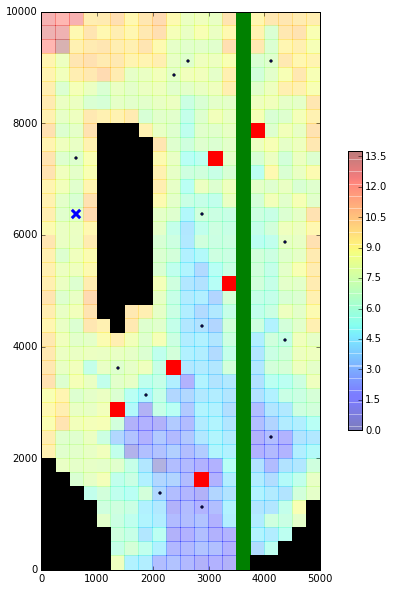

In [2]:
import flopy

# load the model
model_ws = os.path.join("Freyberg","extra_crispy")
ml = flopy.modflow.Modflow.load("freyberg",model_ws=model_ws)

# plot some model attributes
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111,aspect="equal")
ml.upw.hk.plot(axes=[ax],colorbar=True,alpha=0.3)
ml.wel.stress_period_data.plot(axes=[ax])
ml.riv.stress_period_data.plot(axes=[ax])

# plot obs locations
obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),delim_whitespace=True)
obs_x = [ml.dis.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [ml.dis.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.')


# plot particle starting location
loc_line = open(os.path.join(model_ws,ml.name+".locations"),'r').readlines()[-1].strip().split()
r,c = int(loc_line[4]),int(loc_line[5])
x,y = ml.dis.sr.xcentergrid[r-1,c-1],ml.dis.sr.ycentergrid[r-1,c-1]
ax.scatter([x],[y],marker='x',s=70,lw=3)

plt.show


The plot shows the Freyberg (1988) model domain.  The colorflood is the hydraulic conductivity ($\frac{m}{d}$).  Red and green cells coorespond to well-type and river-type boundary conditions. Blue dots and blue 'x' are the locations of water levels used for calibration and the starting point of the particle used for the travel time forecast,respectively.

##Using `pyemu`

In [3]:
import pyemu

First create a linear_analysis object.  We will use `schur`  derived type, which replicates the behavior of the `PREDUNC` suite of PEST.  We pass it the name of the jacobian matrix file.  Since we don't pass an explicit argument for `parcov` or `obscov`, `pyemu` attempts to build them from the parameter bounds and observation weights in a pest control file (.pst) with the same base case name as the jacobian.  Since we are interested in forecast uncertainty as well as parameter uncertainty, we also pass the names of the forecast sensitivity vectors we are interested in, which are stored in the jacobian as well.  Note that the `forecasts` argument can be a mixed list of observation names, other jacobian files or PEST-compatible ASCII matrix files.

In [44]:
# get the list of forecast names from the pest++ argument in the pest control file
jco = os.path.join("freyberg","freyberg.jcb")
pst = pyemu.Pst(jco.replace("jcb","pst"))
forecast_arg = [arg for arg in pst.pestpp_lines[0].split('++') if "forecast" in arg ][0]
forecasts = forecast_arg.replace("forecasts(",'').replace(')','').split(',')
la = pyemu.Schur(jco=jco, forecasts=forecasts,verbose=True)


2015-11-03 14:41:00.718000 starting: pre-loading base components

2015-11-03 14:41:00.718000 starting: loading jco: freyberg\freyberg.jcb

2015-11-03 14:41:00.804000 finished: loading jco: freyberg\freyberg.jcb took: 0:00:00.086000

2015-11-03 14:41:00.804000 starting: loading pst: freyberg\freyberg.pst

2015-11-03 14:41:00.961000 finished: loading pst: freyberg\freyberg.pst took: 0:00:00.157000

2015-11-03 14:41:00.961000 starting: loading parcov

2015-11-03 14:41:01.309000 finished: loading parcov took: 0:00:00.348000

2015-11-03 14:41:01.309000 starting: loading obscov

2015-11-03 14:41:01.902000 finished: loading obscov took: 0:00:00.593000

2015-11-03 14:41:01.902000 starting: loading forecasts

2015-11-03 14:41:01.981000 finished: loading forecasts took: 0:00:00.079000

2015-11-03 14:41:01.981000 finished: pre-loading base components took: 0:00:01.263000

2015-11-03 14:41:01.981000 starting: dropping prior information

2015-11-03 14:41:01.981000 starting: removing 761 prior info 

We can inspect the parcov and obscov attributes by saving them to files.  We can save them PEST-compatible ASCII or binary matrices (`.to_ascii()` or `.to_binary()`), PEST-compatible uncertainty files (`.to_uncfile()`), or simply as numpy ASCII arrays (`numpy.savetxt()`).  In fact, all matrix and covariance objects (including the forecasts) have these methods.  


In [8]:
la.parcov.to_uncfile(jco+"_prior.unc", covmat_file=None)

##Posterior parameter uncertainty analysis
Let's calculate and save the posterior parameter covariance matrix:

In [9]:
la.posterior_parameter.to_ascii(jco+"_post.cov")

You can open this file in a text editor to examine.  The diagonal of this matrix is the posterior variance of each parameter. Since we already calculated the posterior parameter covariance matrix, additional calls to the `posterior_parameter` decorated method only require access:


In [10]:
la.posterior_parameter.to_dataframe().sort().sort(axis=1).iloc[0:3,0:3] #look so nice in the notebook

,hkr00c00,hkr00c01,hkr00c02
hkr00c00,2.499965e-01,-8.837002e-07,-0.000005
hkr00c01,-8.837002e-07,2.499910e-01,-0.000021
hkr00c02,-4.635569e-06,-2.085084e-05,0.249947


We can see the posterior variance of each parameter along the diagonal of this matrix. Now, let's make a simple plot of prior vs posterior uncertainty for the 600 pilot point parameters

,percent_reduction,post_var,prior_var
rch_1,49.884568,0.000238,0.000475
hkr30c15,31.278933,0.171803,0.250000
hkr03c11,26.494859,0.183763,0.250000
hkr34c09,25.096673,0.187258,0.250000
hkr04c10,24.712660,0.188218,0.250000
hkr22c12,22.009284,0.194977,0.250000
hkr25c06,21.114649,0.197213,0.250000
hkr35c12,19.869449,0.200326,0.250000
hkr35c10,18.608329,0.203479,0.250000
hkr04c16,17.240172,0.206900,0.250000


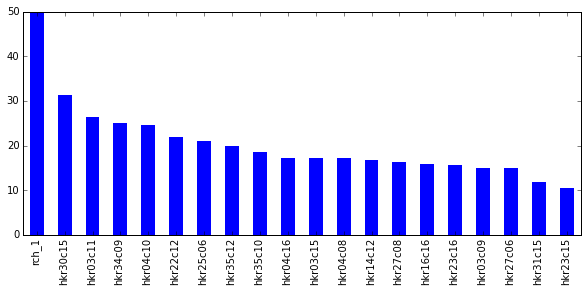

In [11]:
par_sum = la.get_parameter_summary().sort("percent_reduction",ascending=False)
par_sum.loc[par_sum.index[:20],"percent_reduction"].plot(kind="bar",figsize=(10,4),edgecolor="none")
par_sum.iloc[0:10,:]

We can see that calibrating the model to the 13 water levels reduces the uncertainty of the calibration period recharge by 50%.  Additionally, the hydraulic conductivity of many model cell is also reduced.  

,percent_reduction,post_var,prior_var
hkr39c14,0,0.250000,0.250000
hkr01c19,0,0.250000,0.250000
hkr00c19,0,0.250000,0.250000
wf6_2,0,0.014228,0.014228
wf5_2,0,0.014228,0.014228
wf3_2,0,0.014228,0.014228
wf2_2,0,0.014228,0.014228
wf1_2,0,0.014228,0.014228
sy,0,0.250000,0.250000
ss,0,0.250000,0.250000


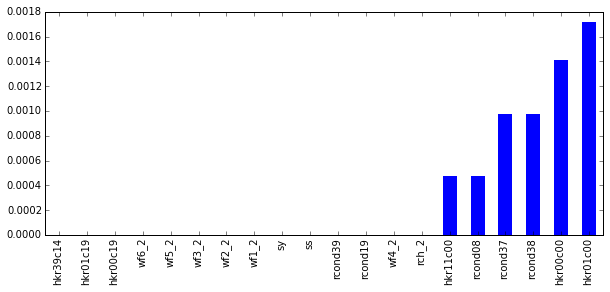

In [12]:
par_sum = la.get_parameter_summary().sort("percent_reduction")
par_sum.loc[par_sum.index[:20],"percent_reduction"].plot(kind="bar",figsize=(10,4),edgecolor="none")
par_sum.iloc[0:10,:]

We see that several parameters are uneffected by calibration - these are mostly parameters that represent forecast period uncertainty, but there are also some hydraulic conductivities

We can also make a map of uncertainty reduction for the hydraulic conductivity parameters  

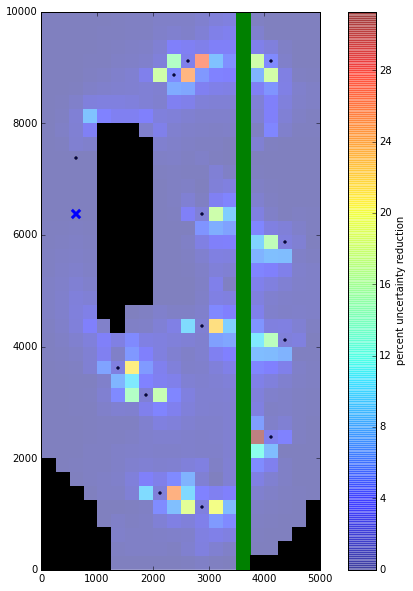

In [28]:
hk_pars = par_sum.loc[par_sum.groupby(lambda x:"hk" in x).groups[True],:]
hk_pars.loc[:,"names"] = hk_pars.index
names = hk_pars.names
hk_pars.loc[:,"i"] = names.apply(lambda x: int(x[3:5]))
hk_pars.loc[:,"j"] = names.apply(lambda x: int(x[6:8]))
unc_array = np.zeros_like(ml.upw.hk[0].array) - 1
for i,j,unc in zip(hk_pars.i,hk_pars.j,hk_pars.percent_reduction):
    unc_array[i,j] = unc 

unc_array[unc_array == -1] = np.NaN

# plot some model attributes
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111,aspect="equal")
cb = ax.imshow(unc_array,interpolation="none",alpha=0.5,extent=ml.dis.sr.get_extent())
plt.colorbar(cb,label="percent uncertainty reduction")
#ml.wel.stress_period_data.plot(axes=[ax])
ml.riv.stress_period_data.plot(axes=[ax])

# plot obs locations
obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),delim_whitespace=True)
obs_x = [ml.dis.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [ml.dis.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.')


# plot particle starting location
loc_line = open(os.path.join(model_ws,ml.name+".locations"),'r').readlines()[-1].strip().split()
r,c = int(loc_line[4]),int(loc_line[5])
x,y = ml.dis.sr.xcentergrid[r-1,c-1],ml.dis.sr.ycentergrid[r-1,c-1]
ax.scatter([x],[y],marker='x',s=70,lw=3)



As you might expect, most of the information in the observations is flowing to the hydraulic conductivity parameters near observations themselves.

In [29]:
prior = la.prior_forecast
print(prior) # dict keyed on forecast name


{'sw_gw_1': 621129.87223585823, 'sw_gw_0': 79634.034592213429, 'travel_time': 37167977.009689406, 'sw_gw_2': 662931.00537485955}


Sometimes, it is more intuitive to think in terms of standard deviation, which in this case has units of ```meters``` and can be thought of as the "+/-" around the model-predicted distance from the left edge of the domain to the three saltwater concentration contours

In [30]:
for pname,var in la.prior_forecast.items():
    print(pname,np.sqrt(var))

sw_gw_1 788.117930411
sw_gw_0 282.195029354
travel_time 6096.55451954
sw_gw_2 814.205751254


##Posterior forecast uncertainty
Now, let's calculate the posterior uncertainty (variance) of each forecast:

In [31]:
post = la.posterior_forecast
for pname,var in post.items():
    print(pname,np.sqrt(var))

sw_gw_1 787.681800039
sw_gw_0 212.760315313
travel_time 5778.42430856
sw_gw_2 814.005679926


That's it - we have completed linear-based uncertainty analysis for a model with 603 parameters and we completed it before actual inversion so we can estimate the worth of continuing and actually completing the expense inversion process!  We can see that the data we have provide atleast some conditioning to each of these forecasts, indicating that the history-matching process is valuable:

In [32]:
la.get_forecast_summary()

,percent_reduction,post_var,prior_var
sw_gw_1,0.110646,620442.618112,621129.872236
sw_gw_0,43.156275,45266.951772,79634.034592
travel_time,10.164098,33390187.489795,37167977.009689
sw_gw_2,0.049139,662605.246952,662931.005375


Notice the spread on the uncertainty reduction: some forecasts benefit more from calibration than others.

##Data worth
Now, let's try to identify which observations are most important to reducing the posterior uncertainty (e.g.the forecast worth of every observation).  We simply recalculate Schur's complement without some observations and see how the posterior forecast uncertainty increases


```importance_of_obesrvation_groups()``` is a thin wrapper that calls the underlying ```importance_of_observations()``` method using the observation groups in the pest control file and stacks the results into a ```pandas DataFrame```.  

lets see if the heads or the concentrations are more important:

In [38]:
df = la.get_importance_dataframe()
df

,sw_gw_0,sw_gw_1,sw_gw_2,travel_time
base,45266.951772,620442.618112,662605.246952,33390187.489795
or16c17_0,46009.162975,620457.760006,662606.092583,33396927.483500
or03c16_0,46517.650426,620459.380623,662606.426544,33404360.463137
or23c17_0,45890.127094,620456.396643,662606.023268,33417313.961082
or35c11_0,45383.665749,620476.801860,662667.701620,34327687.706588
or27c07_0,45476.473772,620448.729766,662605.251329,33413482.170579
or03c10_0,45267.631429,620444.798848,662605.256627,33390547.000153
or22c11_0,45438.014277,620456.475235,662606.306210,33501835.948813
or14c11_0,46344.283861,620478.500585,662606.403687,33394980.342488
or30c16_0,45486.605342,620449.437222,662605.519723,35262109.304061


```base``` row are the results of Schur's complement calculation using all observations.  The increase in posterior forecast uncertainty for each of the 13 water level obseravtions (e.g. or17c17 is the observation in row 18 column 18) show how much forecast uncertainty increases when that particular observation is not used in history matching.  So we see again that each forecast depends of the observations differently

A water-level obseravtion for each active model cell was also "carried" in the pest control file.  This means we can run this same analysis to find the best next place to collect a new water level.  This takes a little longer because it is rerunning the schur's complement calculations many times:

In [45]:
obs_dict = {}
for oname in la.pst.obs_names:
    if oname.startswith("o") and oname not in obs.name:
        obs_dict[oname] = oname
print(len(obs_dict))

2115


In [46]:
df_full = la.get_importance_dataframe(obs_dict)

2015-11-03 14:41:18.067000 starting: calculating importance of observations

2015-11-03 14:41:18.067000 starting: propagating posterior to predictions

2015-11-03 14:41:18.067000 starting: Schur's complement

2015-11-03 14:41:18.422000 starting: xtqx

2015-11-03 14:41:18.735000 finished: xtqx took: 0:00:00.313000

2015-11-03 14:41:18.907000 finished: Schur's complement took: 0:00:00.840000

2015-11-03 14:41:18.922000 finished: propagating posterior to predictions took: 0:00:00.855000

2015-11-03 14:41:18.922000 starting: calculating contribution from: or13c14_1


2015-11-03 14:41:24.817000 finished: calculating contribution from: or13c14_1
 took: 0:00:05.895000

2015-11-03 14:41:24.817000 starting: calculating contribution from: or13c14_0


2015-11-03 14:41:30.579000 finished: calculating contribution from: or13c14_0
 took: 0:00:05.762000

2015-11-03 14:41:30.594000 starting: calculating contribution from: or13c14_2


2015-11-03 14:41:36.478000 finished: calculating contribution from: 

KeyboardInterrupt: 

##parameter contribution to uncertainty
Lets look at which parameters are contributing most to forecast uncertainty.  for demostration purposes, lets group the parameters by parameter group name.

In [47]:
df = la.get_contribution_dataframe_groups()
df

2015-11-03 14:43:41.260000 starting: calculating contribution from parameters

2015-11-03 14:43:41.260000 starting: propagating prior to predictions

2015-11-03 14:43:41.308000 finished: propagating prior to predictions took: 0:00:00.048000

2015-11-03 14:43:41.308000 starting: calculating contribution from: ['rch_1', 'rch_2']


2015-11-03 14:43:50.658000 finished: calculating contribution from: ['rch_1', 'rch_2']
 took: 0:00:09.350000

2015-11-03 14:43:50.658000 starting: calculating contribution from: ['rcond00', 'rcond01', 'rcond02', 'rcond03', 'rcond04', 'rcond05', 'rcond06', 'rcond07', 'rcond08', 'rcond09', 'rcond10', 'rcond11', 'rcond12', 'rcond13', 'rcond14', 'rcond15', 'rcond16', 'rcond17', 'rcond18', 'rcond19', 'rcond20', 'rcond21', 'rcond22', 'rcond23', 'rcond24', 'rcond25', 'rcond26', 'rcond27', 'rcond28', 'rcond29', 'rcond30', 'rcond31', 'rcond32', 'rcond33', 'rcond34', 'rcond35', 'rcond36', 'rcond37', 'rcond38', 'rcond39']


2015-11-03 14:43:59.583000 finished: calculating

sw_gw_0                                    sw_gw_1  \
        percent_reduce          post         prior percent_reduce   
base         43.156275  45266.951772  79634.034592       0.110646   
rch          12.301504   3900.047023   4447.108198       0.168021   
rcond        43.177485  45244.828949  79624.827130       0.110633   
storage      43.156275  45266.951772  79634.034592       0.129891   
welflux      43.743394  43617.767683  77533.592215       0.130449   
hk           98.743279    971.402233  77296.576233       0.134450   

                                             sw_gw_2                 \
                  post          prior percent_reduce           post   
base     620442.618112  621129.872236       0.049139  662605.246952   
rch      185502.204821  185814.411201       0.369992   99058.417661   
rcond    620437.848843  621125.016889       0.049117  662600.886403   
storage  528412.812692  529100.066815       0.049139  662605.246818   
welflux  527751.898672  528441.245961       0.058322  564243.327297   
hk       619205.103398  620038.748077       0.000009  661867.579093   

                          travel_time                                    
                 prior percent_reduce             post            prior  
base     662931.005375      10.164098  33390187.489795  37167977.009689  
rch       99426.286977      12.547741  29789240.591144  34063431.732342  
rcond    662926.494620      10.182060  33378116.795841  37161970.853476  
storage  662931.005241      10.164098  33390187.489795  37167977.009689  
welflux  564572.594781      10.282171  33132696.770939  36929891.310551  
hk       661867.639881       0.008877   3348339.887610   3348637.132700

We see some interesting results here.  The sw-gw flux during calibration (sw_gw_0) is more influenced by recharge unceratinty, which the travel time forecast is controlled by hydraulic conductivity uncertainty.  Furthermore, the two forecast period sw-gw flux forecasts are also influenced by recharge uncertainty, but it is the recharge and water use during the forecast period (recharge parameter rch_2 and well flux parameters wf*_2) as well as storage parameters. Unfortunately these parameters are not effected by calibration.  Therefore the foreacasts that depend on these parameters show no uncertainty reduction by calibration.  So if we are most interested in sw-gw exchange under future climate and water use conditions, calibration is not doing any good.